# 2022-01-31 Formulation

Wednesday (Feb 2) we'll be back in person (if you want to be) in FLMG 157.

## Last time

* Derive Newton's method via fixed point convergence theory
* Newton methods in computing culture

## Today

* Breaking Newton's method
* Exploration
* Multiple roots
* Conditioning of the rootfinding problem
* Forward and backward stability

In [1]:
using Plots
default(linewidth=4, legendfontsize=12)

function newton_hist(f, fp, x0; tol=1e-12)
    x = x0
    hist = []
    for k in 1:100 # max number of iterations
        fx = f(x)
        fpx = fp(x)
        push!(hist, [x fx fpx])
        if abs(fx) < tol
            return vcat(hist...)
        end
        x = x - fx / fpx
    end
end

fp (generic function with 1 method)

# Formulations are not unique (functions)

If $x = g(x)$ then
$$x = \underbrace{x + h(x) \big(g(x) - x\big)}_{g_3(x)}$$
for any smooth $h(x) \ne 0$. Can we choose $h(x)$ to make $\lvert g_3'(x) \rvert$ small?

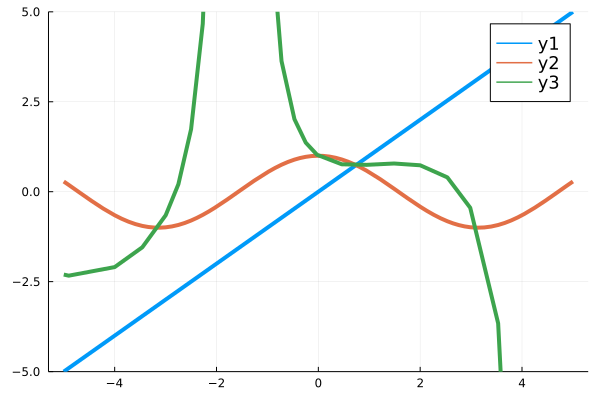

In [5]:
g(x) = cos(x)
gp(x) = -sin(x)
h(x) = -1 / (gp(x) - 1)
g3(x) = x + h(x) * (g(x) - x)
plot([x-> x, cos, g3], ylims=(-5, 5))

* We don't know $g'(x_*)$ in advance because we don't know $x_*$ yet.
* This method converges very fast
* We actually just derived Newton's method.

# Newton's method by fixed point convergence

* A rootfinding problem $f(x) = 0$ can be converted to a fixed point problem $$x = x + f(x) =: g(x)$$ but there is no guarantee that $g'(x_*) = 1 + f'(x_*)$ will have magnitude less than 1.
* Problem-specific algebraic manipulation can be used to make $|g'(x_*)|$ small.
* $x = x + h(x) f(x)$ is also a valid formulation for any $h(x)$ bounded away from $0$.
* Can we choose $h(x)$ such that $$ g'(x) = 1 + h'(x) f(x) + h(x) f'(x) = 0$$ when $f(x) = 0$?

In other words,
$$ x_{k+1} = x_k + \underbrace{\frac{-1}{f'(x_k)}}_{h(x_k)} f(x_k)  . $$

# Quadratic convergence!

$$ \left\lvert \frac{e_{k+1}}{e_k} \right\rvert \to \lvert g'(x_*) \rvert $$

* What does it mean that $g'(x_*) = 0$?
* It turns out that Newton's method has _locally **q-quadratic**_ convergence to simple roots,
$$\lim_{k \to \infty} \frac{|e_{k+1}|}{|e_k|^2} < \infty.$$
* "The number of correct digits doubles each iteration."
* Now that we know how to make a good guess accurate, the effort lies in getting a good guess.

# Rootfinding methods outlook

* Newton methods are immensely successful
  * Convergence theory is local; we need good initial guesses (activity)
  * Computing the derivative $f'(x)$ is *intrusive*
    * Avoided by secant methods (approximate the derivative; activity)
    * Algorithmic or numerical differentiation (future topics)
  * Bisection is robust when conditions are met
  * Line search (activity)
  * When does Newton diverge?

* More topics
  * Find *all* the roots
  * Use Newton-type methods with bounds
  * Times when Newton converges slowly

# Exploratory rootfinding

* Find a function $f(x)$ that models something you're interested in. You could consider nonlinear physical models (aerodynamic drag, nonlinear elasticity), behavioral models, probability distributions, or anything else that that catches your interest. Implement the function in Julia or another language.

* Consider how you might know the output of such functions, but not an input. Think from the position of different stakeholders: is the equation used differently by an experimentalist collecting data versus by someone making predictions through simulation? How about a company or government reasoning about people versus the people their decisions may impact?

* Formulate the map from known to desired data as a rootfinding problem and try one or more methods (Newton, bisection, etc., or use a rootfinding library).

* Plot the inverse function (output versus input) from the standpoint of one or more stakeholder. Are there interesting inflection points? Are the methods reliable?

* If there are a hierarchy of models for the application you're interested in, consider using a simpler model to provide an initial guess to a more complicated model.

# Equation of state example

Consider an [equation of state](https://en.wikipedia.org/wiki/Real_gas#Beattie%E2%80%93Bridgeman_model) for a real gas, which might provide pressure $p(T, \rho)$ as a function of temperature $T$ and density $\rho = 1/v$.

* An experimentalist can measure temperature and pressure, and will need to solve for density (which is difficult to measure directly).
* A simulation might know (at each cell or mesh point, at each time step) the density and internal energy, and need to compute pressure (and maybe temperature).
* An analyst might have access to simulation output and wish to compute entropy (a thermodynamic property whose change reflects irreversible processes, and can be used to assess accuracy/stability of a simulation or efficiency of a machine).

The above highlights how many equations are incomplete, failing to model how related quantities (internal energy and entropy in this case) depend on the other quantities. Standardization bodies (such as NIST, here in Boulder) and practitioners often prefer models that intrinsically provide a complete set of consistent relations. An elegent methodology for equations of state for gasses and fluids is by way of the [Helmholtz free energy](http://www.coolprop.org/fluid_properties/PurePseudoPure.html#pure-and-pseudo-pure-fluid-properties), which is not observable, but whose partial derivatives define a complete set of thermodynamic properties. The [CoolProp](http://www.coolprop.org) software has highly accurate models for many gasses, and practitioners often build less expensive models for narrower ranges of theromdynamic conditions.

# Roots with multiplicity

There are multiple ways to represent (monic) polynomials

\begin{align}
f(x) &= (x - a_1) (x - a_2) & g(x) &= x^2 \underbrace{- (a_1 + a_2)}_{b_1} x + \underbrace{a_1 a_2}_{b_2}
\end{align}

In [87]:
poly_eval_prod(x, a) = prod(x .- a)
function poly_eval_sum(x, b)
    sum = 1
    for c in b
        # This is known as Horner's rule
        sum = x * sum + c
    end
    sum
end

eps = 0
a = [1e5, 1e5*(1)] # tiny perturbation to root
b = [-(a[1] + a[2])*(1+eps), # tiny perturbation to monomial coefficent
    a[1]*a[2]]
f(x) = poly_eval_prod(x, a)
g(x) = poly_eval_sum(x, b)

g (generic function with 1 method)

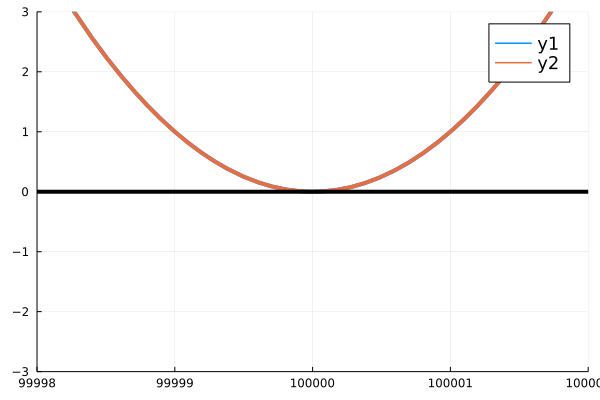

In [88]:
plot([f, g], xlims=(a[1]-2, a[2]+2), ylims=(-3, 3))
plot!(zero, color=:black, label=:none)

* Perturbing the coefficient in the tenth digit made the difference between one root and two.
* The distance between the roots was big when $b_1$ was perturbed.

# How did the roots move?
Take two roots at $x=a$ and perturb the middle coefficient.
\begin{align}
x^2 \underbrace{- 2a(1 + \epsilon)}_{b_1} x + \underbrace{a^2}_{b_2} = 0
\end{align}

Analytically, we know the roots are at

\begin{align}
\frac{b_1}{2} \pm \sqrt{\frac{b_1^2}{4} - b_2} 
&= a(1+\epsilon) \pm \sqrt{a^2(1+\epsilon)^2 - a^2} \\
&= a(1+\epsilon) \pm a \sqrt{2 \epsilon + \epsilon^2} \\
&\approx a \Bigl(1 + \epsilon \pm \sqrt{2 \epsilon} \Bigr).
\end{align}

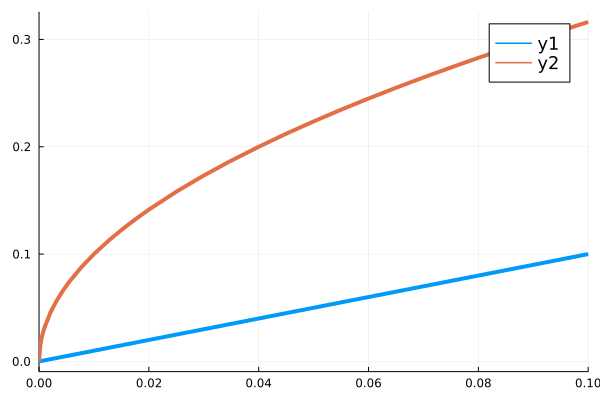

In [89]:
plot([x->x, sqrt], xlims=(0, .1))

Note that condition number is well behaved.
$$ \kappa(\sqrt{\epsilon}) = \frac{1}{2\sqrt{\epsilon}} \frac{\epsilon}{\sqrt{\epsilon}} = \frac 1 2$$

# What does Newton find?

In [94]:
hist = newton_hist(g, x -> 2*x + b[1], 1.1e5; tol=1e-14)

25×3 Matrix{Float64}:
 110000.0             1.0e8        20000.0
 105000.0             2.5e7        10000.0
 102500.0             6.25e6        5000.0
 101250.0             1.5625e6      2500.0
 100625.0        390625.0           1250.0
      1.00312e5   97656.2            625.0
      1.00156e5   24414.1            312.5
      1.00078e5    6103.52           156.25
      1.00039e5    1525.88            78.125
      1.0002e5      381.47            39.0625
      1.0001e5       95.3674          19.5312
      1.00005e5      23.8419           9.76562
      1.00002e5       5.96046          4.88281
      1.00001e5       1.49012          2.44141
      1.00001e5       0.372528         1.2207
      1.0e5           0.093132         0.610353
      1.0e5           0.023283         0.305179
      1.0e5           0.00582123       0.152593
 100000.0             0.00145531       0.0762955
 100000.0             0.000364304      0.0381463
 100000.0             9.15527e-5       0.0190459
 100000.0         

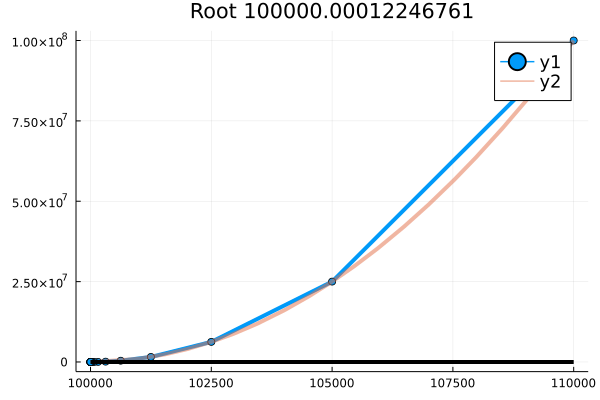

In [95]:
plot(hist[:,1], hist[:,2], seriestype=:path, marker=:auto)
plot!(g, title="Root $(hist[end,1])", alpha=.5)
plot!(zero, color=:black, label=:none)

* Convergence is kinda slow.
* The solution is not nearly as accurate as machine precision.

# Using `Polynomials`

Julia has a nice package to evaluate and manipulate polynomials. The coefficients are given in the other order $b_0 + b_1 x + b_2 x^2 + \dotsb$.

In [97]:
using Polynomials
@show fpoly = Polynomial([2, -3, 1])
@show gpoly = fromroots([1, 2])
derivative(gpoly)

fpoly = Polynomial([2, -3, 1]) = Polynomial(2 - 3*x + x^2)
gpoly = fromroots([1, 2]) = Polynomial(2 - 3*x + x^2)


Polynomial(-3 + 2*x)

In [98]:
newton_hist(gpoly, derivative(gpoly), 3)

7×3 Matrix{Float64}:
 3.0      2.0          3.0
 2.33333  0.444444     1.66667
 2.06667  0.0711111    1.13333
 2.00392  0.00393695   1.00784
 2.00002  1.52593e-5   1.00003
 2.0      2.32831e-10  1.0
 2.0      0.0          1.0

# Finding all roots of polynomials

In [108]:
roots(Polynomial([1e10, -2e5*(1 + 1e-10), 1]))

2-element Vector{Float64}:
  99998.58579643762
 100001.41422356237

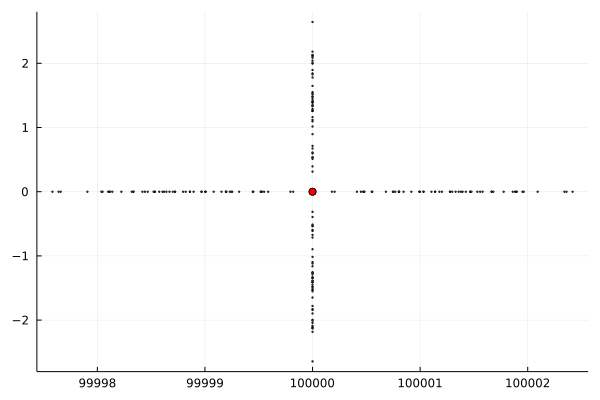

In [156]:
p = fromroots([0., 0.] .+ 1e5)
xs = roots(p)
scatter(real(xs), imag(xs), color=:red)
for i in 1:100
    r = randn(length(p)) # normally distributed mean 0, stddev 1
    q = copy(p)
    q[:] .*= 1 .+ 1e-10 * r
    xs = roots(q)
    scatter!(real(xs), imag(xs), markersize=1)
end
plot!(legend=:none)

> ## [Fundamental Theorem of Algebra](https://en.wikipedia.org/wiki/Fundamental_theorem_of_algebra)
>
> Every non-zero, single-variable, degree $n$ polynomial with complex coefficients has, counted with multiplicity, exactly $n$ complex roots.

# Wilkinson's polynomial

Suppose we add more terms
$$ w(x) = \prod_{k=1}^{20} (x - k) = (x - 1) (x - 2) \dotsb (x - 20) = \sum_{k=0}^{20} b_k x^k $$

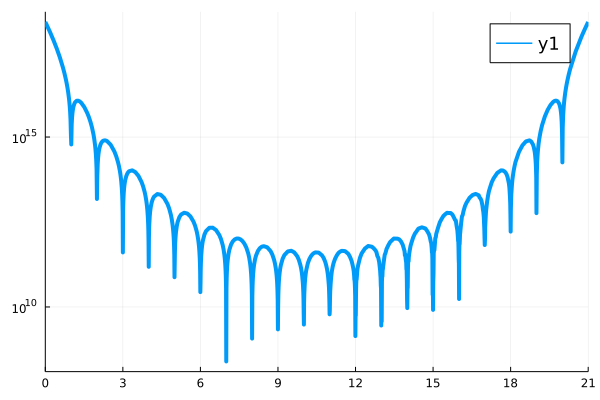

In [149]:
n = 20
a = collect(1.:n)
w = fromroots(a)
#w[10] *= 1 + 1e-12
plot(x -> abs(w(x)), xlims=(0, n+1), yscale=:log10)

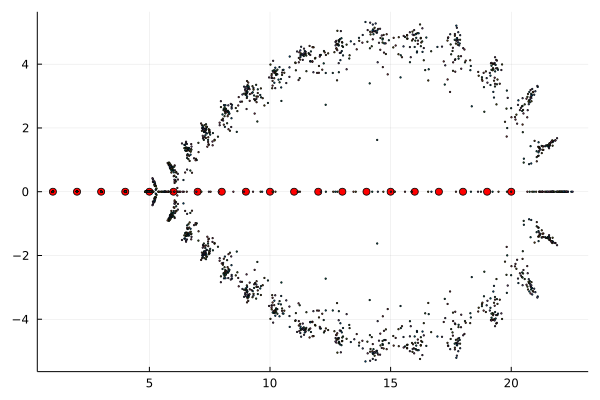

In [158]:
w = fromroots(a)
scatter(a, zero(a), color=:red)
for i in 1:100
    r = randn(length(w))
    q = copy(w)
    q[:] .*= 1 .+ 1e-10 * r
    xs = roots(q)
    scatter!(real(xs), imag(xs), markersize=1)
end
plot!(legend=:none)

# Which is better to model inputs to a rootfinder?

* A: coefficients $a_k$ in $$p(x) = \prod_k (x - a_k)$$

* B: coefficients $b_k$ in $$p(x) = \sum_k b_k x^k$$

## Figure from Trefethen and Bau (1999)
<img alt="Ill conditioning of roots of Wilkinson's polynomial" src="../img/TB-Wilkinson.png" width="90%" />

# [Forward vs backward error and stability](https://fncbook.github.io/fnc/intro/stability.html#backward-error)

<img src="https://fncbook.github.io/fnc/_images/backwarderror.svg" width="90%" />

## Stability
**"nearly the right answer to nearly the right question"**
$$ \frac{\lvert \tilde f(x) - f(\tilde x) \rvert}{| f(\tilde x) |} \in O(\epsilon_{\text{machine}}) $$
for some $\tilde x$ that is close to $x$

## Backward Stability
**"exactly the right answer to nearly the right question"**
$$ \tilde f(x) = f(\tilde x) $$
for some $\tilde x$ that is close to $x$

* Every backward stable algorithm is stable.
* Not every stable algorithm is backward stable.

# Map angle to the unit circle

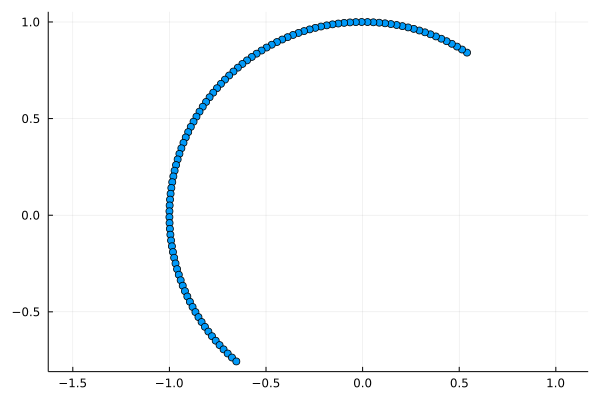

In [189]:
theta = 1 .+ LinRange(0, 3, 100)
scatter(cos.(theta), sin.(theta), legend=:none, aspect_ratio=:equal)

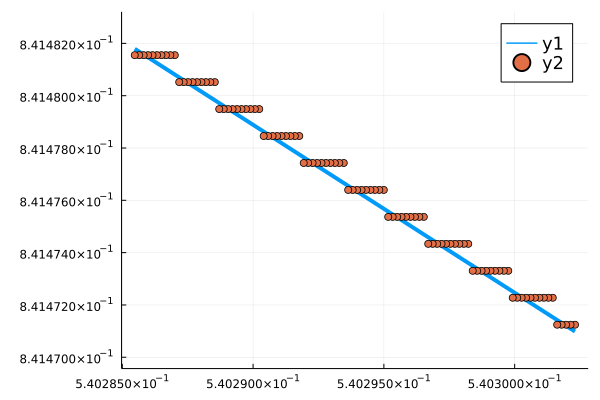

In [179]:
theta = LinRange(1., 1+2e-5, 100)
mysin(t) = cos(t - (1e10+1)*pi/2)
plot(cos.(theta), sin.(theta), aspect_ratio=:equal)
scatter!(cos.(theta), mysin.(theta))

## Are we observing A=stabiltiy, B=backward stability, or C=neither?

* The numbers $(\widetilde\cos \theta, \widetilde\sin \theta = (\operatorname{fl}(\cos \theta), \operatorname{fl}(\sin\theta))$ do not lie exactly on the unit circles.
  * There does not exist a $\tilde\theta$ such that $(\widetilde\cos \theta, \widetilde \sin\theta) = (\cos\tilde\theta, \sin\tilde\theta)$

# Accuracy of backward stable algorithms (Theorem)

A backward stable algorithm for computing $f(x)$ has relative accuracy
$$ \left\lvert \frac{\tilde f(x) - f(x)}{f(x)} \right\rvert \lesssim \kappa(f) \epsilon_{\text{machine}} . $$
Backward stability is generally the best we can hope for.

In practice, it is rarely possible for a function to be backward stable when the output space is higher dimensional than the input space.